In [1]:
import pandas as pd
import numpy as np
from statistics import stdev 
import pickle
from datetime import date
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns

KOR_ticker = pd.read_csv('data/KOR_ticker.csv', index_col=0)
KOR_ticker['종목코드'] = KOR_ticker['종목코드'].astype(np.str).str.zfill(6)

KOR_value = pd.read_csv('data/KOR_value.csv', index_col=0)
KOR_value.index = KOR_value.index.astype(np.str).str.zfill(6)

KOR_price = pd.read_csv('data/KOR_price.csv', index_col = 0)
with open('data/KOR_fs.pickle', 'rb') as f:
    KOR_fs = pickle.load(f)
    
if date.today().month in(1,2,3):
    num_col = KOR_fs['매출액'].columns.str[0:4].get_loc(str(date.today().year - 2))
else:
    num_col = KOR_fs['매출액'].columns.str[0:4].get_loc(str(date.today().year - 1))
    
q_roe = (KOR_fs['지배주주순이익'] / KOR_fs['자본']).iloc[:, num_col]
q_gpa = (KOR_fs['매출총이익'] / KOR_fs['자산']).iloc[:, num_col]
q_cfo = (KOR_fs['영업활동으로인한현금흐름'] / KOR_fs['자산']).iloc[:, num_col]

q_profit = pd.concat([q_roe, q_gpa, q_cfo], axis = 1)
q_profit.columns = ['ROE', 'GPA', 'CFO']    

factor_quality = q_profit.rank(ascending = False, axis = 0).apply(zscore, nan_policy='omit').sum(axis = 1, skipna=False)
factor_value = KOR_value.rank(axis = 0).apply(zscore, nan_policy='omit').sum(axis = 1, skipna=False)

ret = KOR_price.pct_change()

ret_3m = ret.iloc[-60: ].apply(lambda x: (x+1).prod()-1)
ret_6m = ret.iloc[-120: ].apply(lambda x: (x+1).prod()-1)
ret_12m = ret.iloc[-252: ].apply(lambda x: (x+1).prod()-1)

ret_bind = pd.concat([ret_3m, ret_6m, ret_12m], axis = 1)
ret_bind.columns = ['3M', '6M', '12M']
factor_mom = ret_bind.rank(ascending = False, axis = 0).apply(zscore, nan_policy='omit').sum(axis = 1, skipna=False)

factor_bind = pd.concat([factor_quality, factor_value, factor_mom], axis = 1)
factor_bind.columns = ['Quality', 'Value', 'Momentum']

factor_allocation = [0.33, 0.33, 0.33]

factor_qvm = (factor_bind.apply(zscore, nan_policy='omit') * factor_allocation).sum(axis = 1, skipna=False)
invest_qvm = (factor_qvm.rank() <= 30).values

In [213]:
from functools import reduce

df_list = [KOR_ticker[['종목코드', '종목명']].set_index('종목코드'), # 티커
           q_profit, # 퀄리티
           KOR_value, # 밸류
           ret_bind # 모멘텀
          ]

df = reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how='inner'), df_list)
df['select'] = 'N'
df.loc[invest_qvm, 'select'] = 'Y'

df.head()

,종목명,ROE,GPA,CFO,PER,PBR,PCR,PSR,3M,6M,12M,select
005930,삼성전자,0.094550,0.244077,0.172609,19.219868,1.817233,7.680882,2.117597,-0.050000,0.372742,0.716632,N
000660,SK하이닉스,0.091604,0.151890,0.173021,21.357349,1.956426,8.246823,3.183544,0.074510,0.607981,0.648616,N
035420,NAVER,0.121392,0.311745,0.085058,63.682596,7.730534,44.096413,12.031509,0.285948,0.356897,1.274566,N
051910,LG화학,0.027280,0.152509,0.141120,119.536000,3.260929,10.490713,2.037277,-0.089888,0.434783,2.005059,N
207940,삼성바이오로직스,0.052405,0.064771,0.031459,215.242158,11.279760,256.671747,44.534135,-0.018657,0.156891,0.654088,N


In [2]:
def remove_outlier(df, cutoff = 0.01):
    q_low = df.quantile(cutoff)
    q_hi = df.quantile(1 - cutoff)
    
    df_trim = df.loc[(df > q_low) & (df < q_hi)]
    
    return(df_trim)

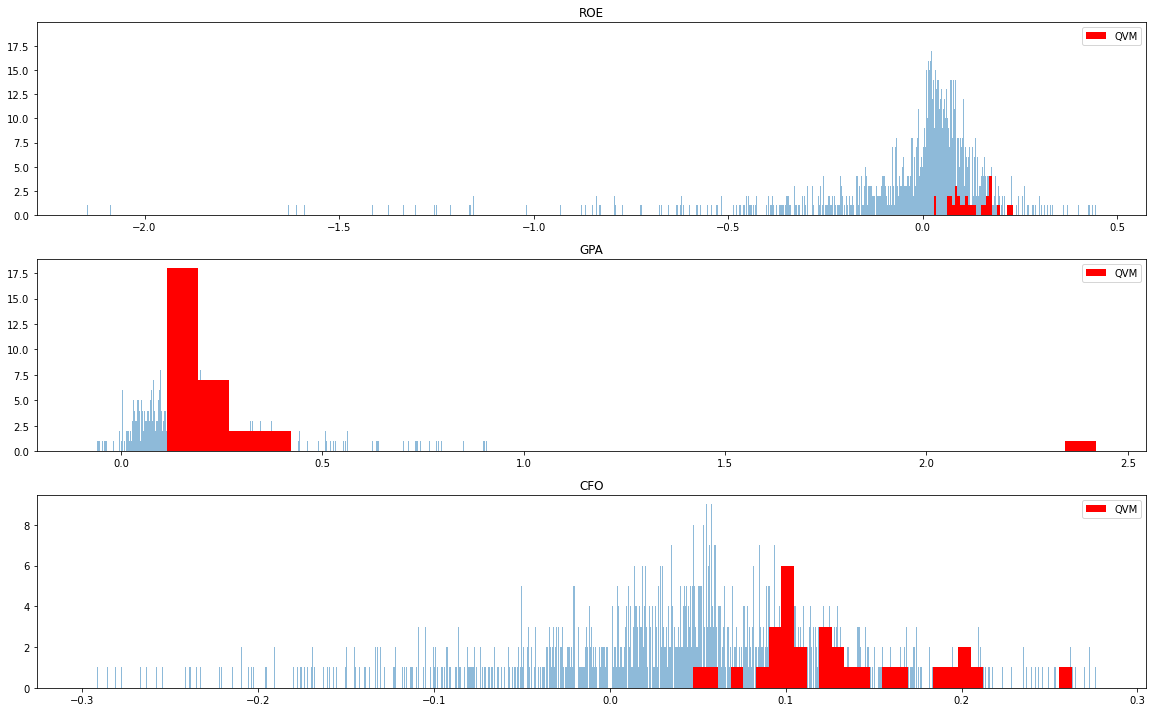

In [38]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

for n, ax in enumerate(axes.flatten()):    
    df = q_profit.iloc[:, n]
    df_mod = remove_outlier(df)    
    l = len(df_mod)
    
    ax.hist(df_mod,  bins = l, alpha = 0.5)     
    ax.hist(q_profit.iloc[invest_qvm, n], bins = 30, color = 'r', label = 'QVM')        
    ax.legend(loc="upper right")
    ax.set_title(q_profit.columns[n], size = 12)
    
fig.tight_layout()     
plt.show()    

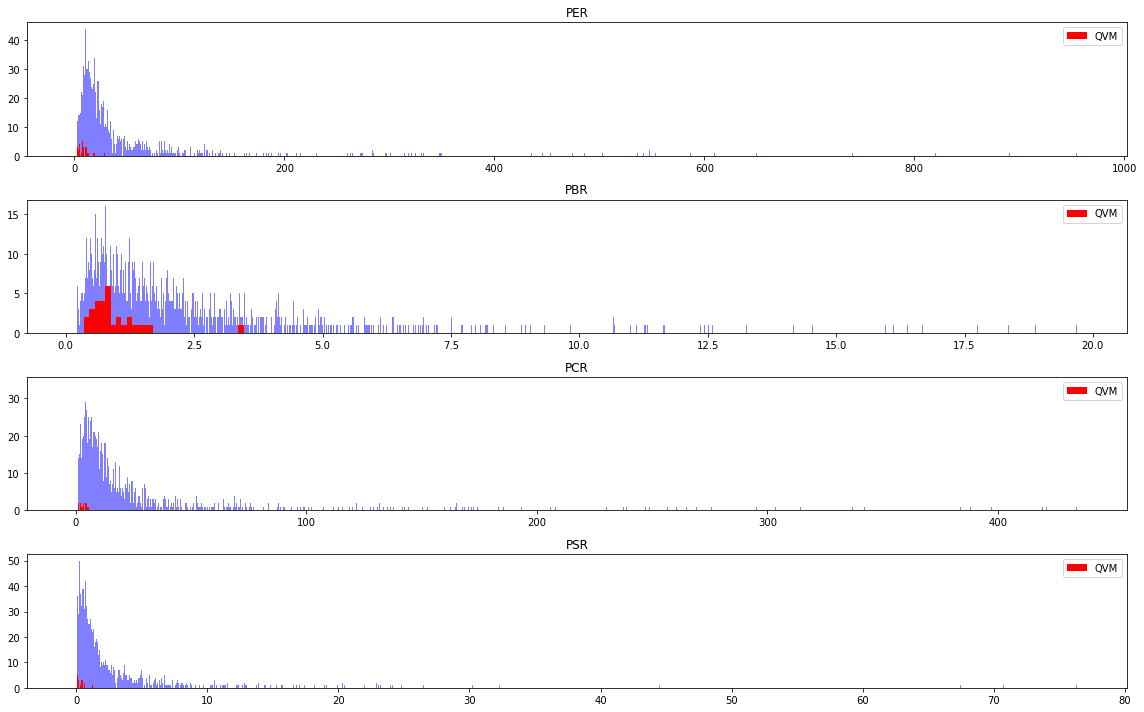

In [76]:
fig, axes = plt.subplots(4, 1, figsize=(16, 10))
for n, ax in enumerate(axes.flatten()):    
    df = KOR_value.iloc[:, n]
    df_mod = remove_outlier(df)    
    l = len(df_mod)
    
    ax.hist(df_mod,  bins = l, alpha = 0.5, color = 'blue')    
    ax.hist(KOR_value.iloc[invest_qvm, n], bins = 30, color = 'r', label = 'QVM')
    ax.legend(loc="upper right")
    plt.yscale('log')
    ax.set_title(KOR_value.columns[n], size = 12)

fig.tight_layout()     
plt.show()    

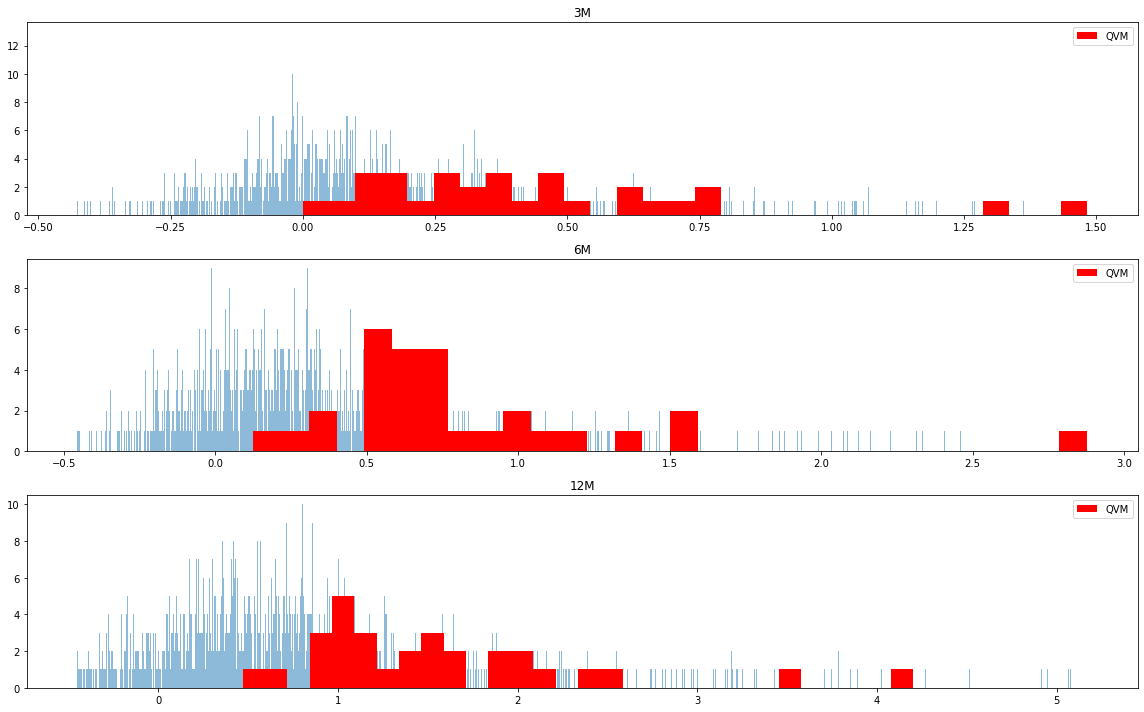

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10))
for n, ax in enumerate(axes.flatten()):    
    df = ret_bind.iloc[:, n]
    df_mod = remove_outlier(df)    
    df_mod = df_mod[df_mod != 0]
    l = len(df_mod)
    
    ax.hist(df_mod,  bins = l, alpha = 0.5, color = 'blue')     
    ax.hist(ret_bind.iloc[invest_qvm, n], bins = 30, color = 'r', label = 'QVM')
    ax.legend(loc="upper right")
    plt.yscale('log')
    ax.set_title(ret_bind.columns[n], size = 12)

fig.tight_layout()     
plt.show()    

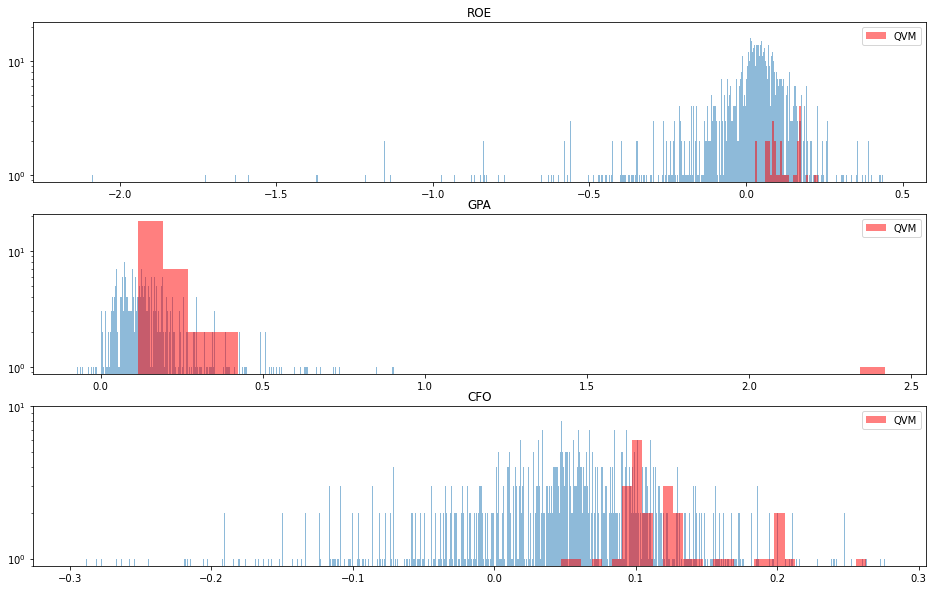

In [75]:
from matplotlib import gridspec

data = q_profit
n = len(data.columns)
fig = plt.subplots(figsize = (16, 10) )

for i in range(n):  
    
    plt.subplot(n, 1, i+1)

    df = data.iloc[:, i]
    df_mod = remove_outlier(df)    
    l = len(df_mod)
    
    plt.hist(df_mod,  bins = l, alpha = 0.5)             
    plt.hist(df.iloc[invest_qvm], bins = 30, color = 'r', alpha = 0.5, label = 'QVM')
    plt.yscale('log')
    plt.legend(loc="upper right")
    plt.gca().title.set_text(data.columns[i])    

plt.show()    